double | Ep    1 | R   10 | ε=1.000
double | Ep  200 | R  -50 | ε=0.101
double | Ep  400 | R  -21 | ε=0.100
double | Ep  600 | R    8 | ε=0.100
double | Ep  800 | R    8 | ε=0.100
double | Ep 1000 | R  -24 | ε=0.100
double | Ep 1200 | R  -50 | ε=0.100
double | Ep 1400 | R   10 | ε=0.100
double | Ep 1600 | R    9 | ε=0.100
double | Ep 1800 | R  -12 | ε=0.100
double | Ep 2000 | R  -14 | ε=0.100
double | Ep 2200 | R    6 | ε=0.100
double | Ep 2400 | R  -50 | ε=0.100
double | Ep 2600 | R  -50 | ε=0.100
double | Ep 2800 | R    9 | ε=0.100
double | Ep 3000 | R  -50 | ε=0.100
Saved random_curves_double.png


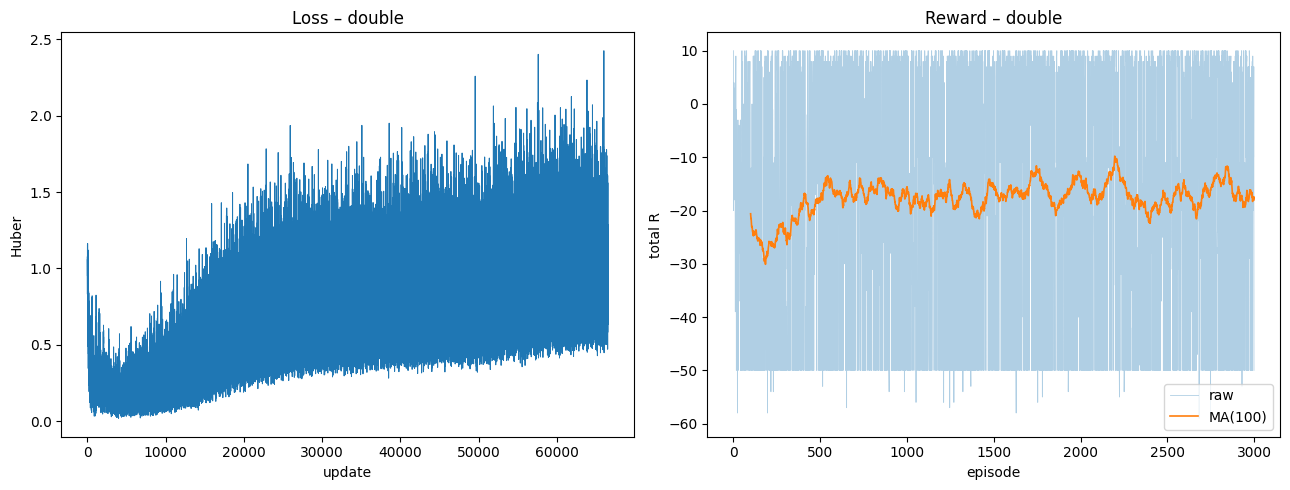

In [ ]:
from __future__ import annotations
import argparse, math, random, os
from collections import deque
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Enable memory growth for GPUs (optional but safe)
for g in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(g, True)

# ---------------------------------------------------------------------------
# Environment wrapper (random mode Gridworld)
# ---------------------------------------------------------------------------
from sample_data.Gridworld import Gridworld  # noqa: E402

def onehot_state(board, size=4):
    lay = np.zeros((4, size, size), dtype=np.float32)
    mp = {"Player": 0, "Goal": 1, "Pit": 2, "Wall": 3}
    for n, p in board.components.items():
        lay[mp[n], p.pos[0], p.pos[1]] = 1
    return lay.flatten()

class GridEnvRandom:
    ACTIONS = {0: 'u', 1: 'd', 2: 'l', 3: 'r'}
    def __init__(self, size=4):
        self.raw = Gridworld(size=size, mode="random")
        self.size = size
    def reset(self):
        self.raw.initGridRand()
        return onehot_state(self.raw.board, self.size)
    def step(self, idx:int)->Tuple[np.ndarray,float,bool]:
        self.raw.makeMove(self.ACTIONS[idx])
        r = self.raw.reward(); done = r in {10,-10}
        return onehot_state(self.raw.board, self.size), float(r), done

# ---------------------------------------------------------------------------
# Replay Buffer
# ---------------------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, cap:int):
        self.buf: deque = deque(maxlen=cap)
    def push(self,s,a,r,s2,d):
        self.buf.append((s,a,r,s2,d))
    def sample(self,b):
        s,a,r,s2,d = map(np.array, zip(*random.sample(self.buf,b)))
        return s,a,r,s2,d
    def __len__(self): return len(self.buf)

# ---------------------------------------------------------------------------
# Network builders
# ---------------------------------------------------------------------------

def build_dqn(inp:int, n_act:int):
    x = inp_layer = keras.Input(shape=(inp,))
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(n_act)(x)
    return keras.Model(inp_layer, out, name='DQN')

def build_dueling(inp:int, n_act:int):
    x = inp_layer = keras.Input(shape=(inp,))
    x = layers.Dense(128, activation='relu')(x)
    v = layers.Dense(128, activation='relu')(x)
    v = layers.Dense(1)(v)
    a = layers.Dense(128, activation='relu')(x)
    a = layers.Dense(n_act)(a)
    a_mean = layers.Lambda(lambda t: tf.expand_dims(tf.reduce_mean(t, axis=1),1))(a)
    q = layers.Add()([v, layers.Subtract()([a, a_mean])])
    return keras.Model(inp_layer, q, name='DuelingDQN')

# ---------------------------------------------------------------------------
# Utils
# ---------------------------------------------------------------------------

def eps_by_step(step:int, start:float,end:float,decay:float):
    return end + (start-end)*math.exp(-step/decay)

def moving_avg(seq:List[float], k:int):
    if k<=1: return seq
    c = np.cumsum(np.insert(seq,0,0))
    ma = (c[k:]-c[:-k])/k
    return [None]*(k-1)+ma.tolist()

# ---------------------------------------------------------------------------
# Training
# ---------------------------------------------------------------------------

def train(cfg):
    env = GridEnvRandom(); state_dim = env.reset().shape[0]; n_act=4
    online = build_dueling(state_dim,n_act) if cfg.algo=='dueling' else build_dqn(state_dim,n_act)
    target = keras.models.clone_model(online); target.set_weights(online.get_weights())

    lr_sched = keras.optimizers.schedules.ExponentialDecay(cfg.lr, decay_steps=2000, decay_rate=0.5, staircase=True)
    opt = keras.optimizers.Adam(lr_sched)
    loss_fn = keras.losses.Huber()
    buf = ReplayBuffer(cfg.buffer_capacity)

    rewards:list[float]=[]; losses:list[float]=[]; step=0
    for ep in range(1,cfg.num_episodes+1):
        s = env.reset(); ep_r=0
        for _ in range(cfg.max_steps):
            eps = eps_by_step(step,cfg.eps_start,cfg.eps_end,cfg.eps_decay)
            a = random.randrange(n_act) if random.random()<eps else int(tf.argmax(online(np.expand_dims(s,0))[0]))
            step+=1
            s2,r,done = env.step(a)
            buf.push(s,a,r,s2,done); s=s2; ep_r+=r

            if len(buf)>=cfg.batch_size:
                bs,ba,br,bs2,bd = buf.sample(cfg.batch_size)
                with tf.GradientTape() as tape:
                    q_pred = tf.gather_nd(online(bs), tf.stack([tf.range(cfg.batch_size), ba],1))
                    if cfg.algo=='double':
                        best = tf.argmax(online(bs2),1,output_type=tf.int32)
                        q_next = tf.gather_nd(target(bs2), tf.stack([tf.range(cfg.batch_size), best],1))
                    else:
                        q_next = tf.reduce_max(target(bs2),1)
                    tgt = br + cfg.gamma*q_next*(1-bd)
                    loss = loss_fn(tgt, q_pred)
                grads = tape.gradient(loss, online.trainable_weights)
                grads = [tf.clip_by_norm(g,5.0) for g in grads]
                opt.apply_gradients(zip(grads, online.trainable_weights))
                losses.append(float(loss))
            if done: break
        rewards.append(ep_r)
        if ep%cfg.target_update_interval==0:
            target.set_weights(online.get_weights())
        if ep%200==0 or ep==1:
            print(f"{cfg.algo:<7}| Ep {ep:4d} | R {ep_r:4.0f} | ε={eps:.3f}")

    # plot
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,5))
    ax1.plot(losses,lw=0.7); ax1.set_title(f"Loss – {cfg.algo}"); ax1.set_xlabel("update"); ax1.set_ylabel("Huber")
    ax2.plot(rewards,alpha=0.35,lw=0.6,label='raw')
    ma = moving_avg(rewards,cfg.smooth)
    if cfg.smooth>1: ax2.plot(ma,lw=1.2,label=f"MA({cfg.smooth})")
    ax2.set_title(f"Reward – {cfg.algo}"); ax2.set_xlabel("episode"); ax2.set_ylabel("total R"); ax2.legend()
    plt.tight_layout(); fname=f"random_curves_{cfg.algo}.png"; fig.savefig(fname)
    print("Saved", fname)

# ---------------------------------------------------------------------------
# CLI
# ---------------------------------------------------------------------------

def get_args():
    p = argparse.ArgumentParser(description="Keras Double/Dueling DQN on random-mode Gridworld")
    p.add_argument("--algo", choices=['double','dueling'], default='double')
    p.add_argument("--num_episodes", type=int, default=3000)
    p.add_argument("--max_steps", type=int, default=50)
    p.add_argument("--batch_size", type=int, default=128)
    p.add_argument("--gamma", type=float, default=0.99)
    p.add_argument("--buffer_capacity", type=int, default=50000)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--target_update_interval", type=int, default=20)
    p.add_argument("--eps_start", type=float, default=1.0)
    p.add_argument("--eps_end", type=float, default=0.1)
    p.add_argument("--eps_decay", type=float, default=800)
    p.add_argument("--smooth", type=int, default=100)
    a,_ = p.parse_known_args(); return a

if __name__ == "__main__":
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    train(get_args())
